### Node2vec

In this tutorial we will illustrate a modern Machine Learning pipeline applied to scholarly data. This should cover:

 * Loading query results data
 * Building a citation network
 * Obtaining an embedding of the network by employing Node2Vec
   * Generating random walks sentences
   * Train a Word2Vec model from it
 * Generate 2D positions from the embedding by using UMAP
 * Interactive visualization of the embedding
 * SemAxis exploration

#### Packages needed

In [1]:
from tqdm.auto import tqdm
import pandas as pd
import xnetwork as xnet
import numpy as np
import igraph as ig
import sys
import os
import cxrandomwalk as rw
import umap
import gensim
import importlib
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import OrderedDict
import matplotlib.patheffects as pe
import scipy.stats as scistats
%matplotlib widget

In [17]:
# Loading a citation network
g = ig.Graph.Read_GML("../../Networks/Nature-Cell-Nature-Physics.gml").simplify()
#attributes:
print(g.vertex_attributes())

['id', 'Community', 'InDegree', 'JournalnormalizedName', 'KCore', 'OutDegree', 'PaperoriginalTitle', 'PaperpaperId', 'Paperyear', 'isQueryPaper', 'year']


#### Setting up some folders and paths

In [5]:
os.makedirs("models", exist_ok=True)
modelPath = "models/citation.model"

os.makedirs("sentences", exist_ok=True)
sentencesPath = "sentences/citation.txt"

#### Fields available for MAG queries

#### Auxiliary functions

In [6]:
from gensim.models.callbacks import CallbackAny2Vec

class MonitorCallback(CallbackAny2Vec):
    def __init__(self,pbar):
        self.pbar = pbar

    def on_epoch_end(self, model):
        self.pbar.update(1)
        self.pbar.refresh() # to show immediately the update

### Simulating random walks in the network

In [9]:
agent = rw.Agent(g.vcount(),np.array(g.get_edgelist()),False);

def make_pbar():
    pbar = None
    def inner(current,total):
        nonlocal pbar
        if(pbar is None):
            pbar= tqdm(total=total);
        pbar.update(current - pbar.n)
    return inner

agent.generateWalks(q=1.0,p=1.0,filename=sentencesPath,walksPerNode=10,verbose=False,updateInterval=100,callback=make_pbar()) #filename="entireData.txt",


  0%|          | 0/80330 [00:00<?, ?it/s]

### Training the word2vec model

In [10]:
monitor = MonitorCallback(tqdm())
gensimModel = gensim.models.Word2Vec(
    gensim.models.word2vec.LineSentence(sentencesPath),
    vector_size=64,
    workers=2,
    min_count=1,
    sg=1,
    callbacks=[monitor]
)#,negative=10)

gensimModel.save(modelPath)


0it [00:00, ?it/s]

### Obtaining the UMAP projection

In [11]:
gensimModel = gensim.models.Word2Vec.load(modelPath)
gensimVector = gensimModel.wv;
reducer = umap.UMAP(n_neighbors=14, min_dist=0.25, n_components=2, metric='cosine',verbose=True)
embedding = reducer.fit_transform(gensimVector.vectors)

keyindex = {int(entry):i for i,entry in enumerate(gensimVector.index_to_key)}
indexkey = [keyindex[index] for index in sorted(keyindex.keys())]
correctOriginalEmbedding = gensimVector.vectors[indexkey,:]
correctEmbedding = embedding[indexkey,:]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.25, n_neighbors=14, verbose=True)


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Thu Mar 10 06:48:03 2022 Construct fuzzy simplicial set
Thu Mar 10 06:48:03 2022 Finding Nearest Neighbors
Thu Mar 10 06:48:03 2022 Building RP forest with 9 trees
Thu Mar 10 06:48:05 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Thu Mar 10 06:48:12 2022 Finished Nearest Neighbor Search
Thu Mar 10 06:48:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Mar 10 06:48:24 2022 Finished embedding


#### Auxiliary functions

In [12]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], amount, c[2])
 

### Interactive visualization
#### Visualization function

In [13]:
def generateVisualization(nameAttribute,sizeAttribute,colorAttribute,nNeighbors,legendColumns = 2, exportFilename = None):
    x = correctEmbedding[:, 0]
    y = correctEmbedding[:, 1]

    names = g.vs[nameAttribute]#np.array([str(i) for i in range(len(x))])
    colorValues = g.vs[colorAttribute]
    from collections import Counter
    valuesCounter = Counter(colorValues)
    if("None" in valuesCounter):
        valuesCounter["None"] = 1
    sortedTitles = [pair[0] for pair in sorted(valuesCounter.items(), key=lambda item: item[1],reverse=True)]
    c2i = {c:i if i<10 else 10 for i,c in enumerate(sortedTitles)}
    c2cc = {c:cm.tab10(i)[0:3]+(0.25,) if i<10 else (0.75,0.75,0.75,0.05) for i,c in enumerate(sortedTitles)} 
    c2ccLight = {c:adjust_lightness(cm.tab10(i)[0:3]+(0.25,),0.98) if i<10 else adjust_lightness((0.75,0.75,0.75,1.00),0.98) for i,c in enumerate(sortedTitles)}
    colors = [c2cc[entry] for entry in colorValues];
    colorsLight = [c2ccLight[entry] for entry in colorValues];
    c = colors
    if(sizeAttribute in g.vertex_attributes()):
        sizes = 1+4*np.log(1.0+np.array(g.vs[sizeAttribute]))
    else:
        sizes = 5

    fig,ax = plt.subplots(figsize=(6,8))
    sc = plt.scatter(x,y,c=c, s=sizes, pickradius=1)

    annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="figure pixels",
                        bbox=dict(boxstyle="round", fc="w",ec="w"),
                        arrowprops=dict(arrowstyle="fancy",lw=0.5))
    annot.set_visible(False)
    xlim = ax.get_xlim()
    linesBack = []
    for _ in range(nNeighbors):
        line = ax.plot([0,0],[0,0],lw=4,c="k",
                       solid_capstyle='round',
                       picker=False)[0]
        line.set_visible(False)
        linesBack.append(line)

    lines = []
    for _ in range(nNeighbors):
        line = ax.plot([0,0],[0,0],lw=2,c="r",
                       solid_capstyle='round',
                       picker=False)[0]
        line.set_visible(False)
        lines.append(line)

    def update_annot(ind):
        selectedIndex = ind["ind"][0]
        annot.xy = sc.get_offsets()[selectedIndex]
        for line in lines:
            line.set_visible(False)
        for line in linesBack:
            line.set_visible(False)
        neighborsData = [(int(i),float(p)) for i,p in gensimModel.wv.most_similar(str(selectedIndex), topn=nNeighbors)]
        for i,(index,p) in enumerate(neighborsData):
            pos = (x[index],y[index])
            line = lines[i]
            lineBack = linesBack[i]
            lineData = line.get_data()
            line.set_xdata([x[selectedIndex],x[index]])
            line.set_ydata([y[selectedIndex],y[index]])
            lineBack.set_xdata([x[selectedIndex],x[index]])
            lineBack.set_ydata([y[selectedIndex],y[index]])
            line.set_visible(True)
            lineBack.set_visible(True)
            line.set_alpha(p)
            lineBack.set_alpha(p)
    #     annot.set_position((-0,-0)) + str(number) + "}$"
        text = "{}".format("\n".join([names[selectedIndex]]+[names[n] for n in [v for v,p in neighborsData]]))
        text = text.replace("$",'\$')
        annot.set_text(text)
        annot.arrow_patch.set_facecolor(c[ind["ind"][0]])
        annot.arrow_patch.set_edgecolor("w")
        annot.get_bbox_patch().set_facecolor(colorsLight[ind["ind"][0]])
        annot.get_bbox_patch().set_alpha(1.0)


    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    for line in lines:
                        line.set_visible(False)
                    for line in linesBack:
                        line.set_visible(False)
                    fig.canvas.draw_idle()
    
    if(exportFilename is None):
        fig.canvas.mpl_connect("button_press_event", hover)
    
    plt.setp(ax, xticks=[], yticks=[]);
    fig.patch.set_visible(False)
    ax.axis('off')
    legend_elements = [Line2D([0], [0],
                        linewidth=0,
                        marker='o',
                        color=c2cc[community][0:3],
                        label=community,
                        # markerfacecolor='g',
                        markersize=3) for community in sortedTitles[0:10]]
    legend_elements+=[Line2D([0], [0],
                        linewidth=0,
                        marker='o',
                        color=(0.75,0.75,0.75),
                        label="Others",
                        # markerfacecolor='g',
                        markersize=3)]
    ax.legend(handles=legend_elements,
              fontsize="small",
              frameon=False,
              fancybox=False,
              ncol=legendColumns,
              bbox_to_anchor=(0.0, 1.1),
              loc='upper left')

    
    fig.subplots_adjust(bottom=0.25,top=0.90,left=0.0,right=1.0)
    if(exportFilename is None):
        plt.show()
    else:
        plt.savefig(exportFilename)
        plt.close()

### Visualization Parameters
Choose the names of the attributes to be used for  visualization and number of neigbohrs to show.

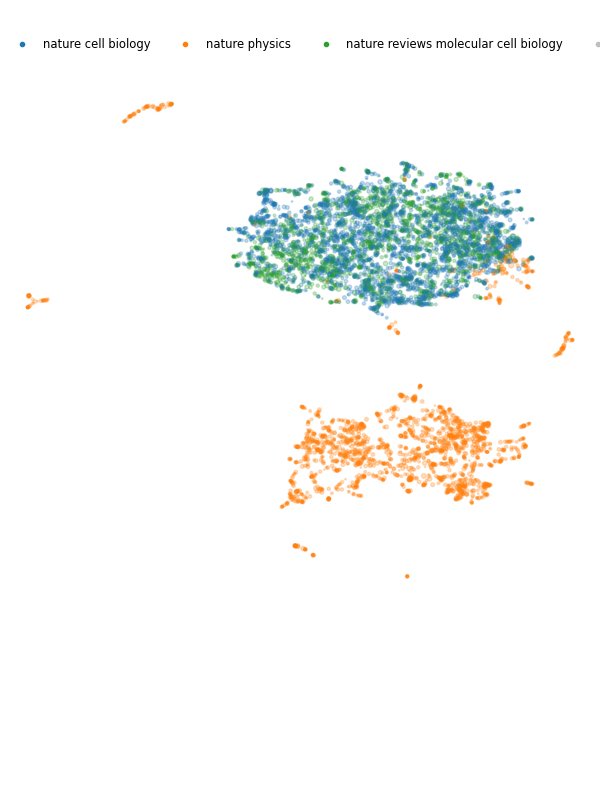

In [16]:
exportFilename = None

#Set paper
generateVisualization(
    nameAttribute = "PaperoriginalTitle",
    sizeAttribute = "InDegree",
    colorAttribute = "JournalnormalizedName",
#     colorAttribute = "Community",
    nNeighbors = 10,
    legendColumns = 4,
    exportFilename=exportFilename
)
####


### SemAxis approach
In this example we use a few samples of extremes for two groups (for instance past for papers published before 2000 and recent for papers published after 2015). Other classes can be used as well, for instnace journals or citations.
Importing code directly from the emlens package (https://github.com/skojaku/emlens).

In [20]:
# Semaxis support from the emlens package (https://github.com/skojaku/emlens)
# https://github.com/skojaku/emlens/blob/main/emlens/semaxis.py
import emlens_semaxis as emlens

#### Paramaters for SemAxis
Here we define the rules to assign nodes to each group. `maxSamples` indicate the number of samples per classes that are going to be used for training.

In [21]:
maxSamples = 20; # max samples per class

nameAttribute = "PaperoriginalTitle"
# groupAttribute ="year"

# lowerBound = np.percentile(sorted(g.vs["year"]),5)
# higherBound = np.percentile(sorted(g.vs["year"]),95)

# groups = {
#     "Recent (>%d)"%higherBound: lambda v : v>=higherBound,
#     "Past (<%d)"%lowerBound: lambda v : v<=lowerBound,
# }

groupAttribute ="JournalnormalizedName"

groups = {
    "Nature Cell Biology": lambda v : v == "nature cell biology",
    "Nature Physics": lambda v : v == "nature physics",
}

labels = np.array(g.vs[nameAttribute])

def groupMap(index):
    groupValue = g.vs[groupAttribute][index]
    for groupName,func  in groups.items():
        if(func(groupValue)):
            return groupName;
    else:
        return None # no group

    
groupIDs = np.array(list(map(groupMap,range(g.vcount()))))
validGroups = np.array([entry is not None for entry in groupIDs])

if(maxSamples>=0):
    for groupName in groups:
        groupIndices = np.where(groupIDs==groupName)[0]
        if(len(groupIndices)>maxSamples):
            validGroups[groupIndices] = False;
            validGroups[np.random.choice(groupIndices,maxSamples,replace=False)] = True
        
        
    

model = emlens.SemAxis()
model.fit(correctOriginalEmbedding[validGroups,:], groupIDs[validGroups])
projectedCoordinates = model.transform(correctOriginalEmbedding)

#### Visualization of the semAxis 

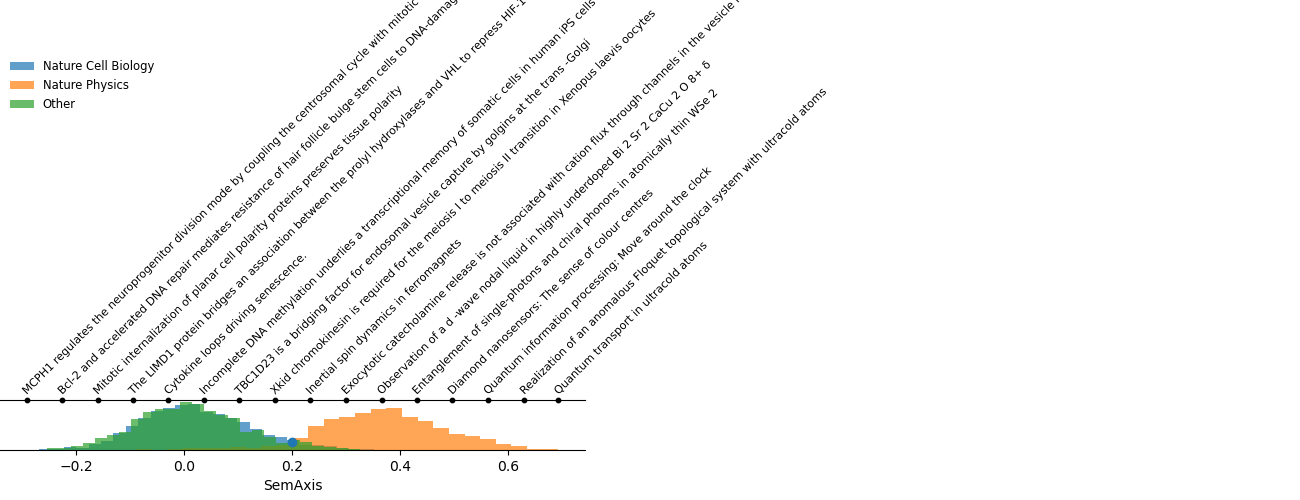

In [23]:
fig,ax = plt.subplots(figsize=(13,5))
otherGroup = np.ones(len(groupIDs),dtype=bool)
bins = 30

for groupName in groups:
    otherGroup*=(groupIDs!=groupName)
    groupCoordinates = projectedCoordinates[groupIDs==groupName]
    if(len(groupCoordinates)):
        p = plt.hist(groupCoordinates,bins=bins,density=True,label=groupName,alpha=0.70)
    
groupCoordinates = projectedCoordinates[otherGroup]
if(len(groupCoordinates)):
    p = plt.hist(groupCoordinates,bins=bins,density=True,label="Other",alpha=0.70)
    

# average

fig.subplots_adjust(bottom=0.10,top=0.20,left=0.0,right=0.45)
ax.legend(fontsize="small",
          frameon=False,
          fancybox=False,
          bbox_to_anchor=(0.0, 8),
          loc='upper left')

plt.setp(ax, yticks=[]);
fig.patch.set_visible(False)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlabel("SemAxis")

breaks = 15
step = (np.max(projectedCoordinates)-np.min(projectedCoordinates))/breaks;
addedIndices = []
sortedIndices = sorted(range(len(projectedCoordinates)),key=lambda i: projectedCoordinates[i])
for i in sortedIndices:
    if(projectedCoordinates[i] >= np.min(projectedCoordinates)+len(addedIndices)*step):
        addedIndices.append(i)
        
for index in addedIndices:
#     index = 6069
    groupName = groupIDs[index]
    plt.scatter([projectedCoordinates[index]],[1.0],s=10, c = "k",
                clip_on=False,
                transform = ax.get_xaxis_transform())
    textActor = ax.text(projectedCoordinates[index], 1.1, labels[index], fontsize=8,
                  rotation=45, rotation_mode='anchor',
    #               transform_rotates_text=True,
                   transform = ax.get_xaxis_transform())
    textActor.set_path_effects([pe.Stroke(linewidth=2, foreground='white'),
                       pe.Normal()])

ax.scatter(0.2, projectedCoordinates[index])

plt.show()


### Example analysis
Here we check if the semiaxis correlate with publication year

In [ ]:
plt.figure()
x = g.vs["year"]
y = projectedCoordinates
plt.title("Pearson Corr.: %.2f, Spearman Corr.: %.2f"%(scistats.pearsonr(x, y)[0],scistats.spearmanr(x, y)[0]))
plt.hexbin(x,y,gridsize=25,cmap=cm.inferno)
plt.xlabel("Year")
plt.ylabel("SemAxis")
plt.show()
if(interactive):
    plt.show()
else:
    plt.savefig("figures/yearCorrelation.pdf")
    plt.close()